In [15]:
from string import punctuation
import re
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords
from pymystem3 import Mystem
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

nltk.download("stopwords")
display(HTML("<style>.container { width:99% !important; }</style>"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayuishkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")


def preprocess_text(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    return ' '.join(tokens)

In [8]:
TRAIN_SIZE = 0.8
SHUFFLE = False


def my_split(df):
    # ?? Сортим
    df = df.sort_values('date')
    
    cats = df.groupby('clipContentCategory')['asr'].count().sort_values(ascending=False).index
    cat_to_id = {cat: i for i, cat in enumerate(cats)}
    id_to_cat = {}
    for cat, idx in cat_to_id.items():
        id_to_cat[idx] = cat
    
    X = df.drop(columns = ['clipContentCategory'])[['descr_tokens', 'asr_tokens', 'confidence_asr']].copy()
    y = df['clipContentCategory'].apply(lambda x: cat_to_id[x])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        train_size=TRAIN_SIZE, 
        shuffle=SHUFFLE,
    )
    
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    
    print(X_train.shape), print(y_train.shape)
    print(X_test.shape), print(y_test.shape)
    
    meta = (cat_to_id, id_to_cat, )
    
    return X_train, X_test, y_train, y_test, meta

In [4]:
def BoW(X_train, X_test):
    count_vect = CountVectorizer()
    X_train_descr = pd.DataFrame(count_vect.fit_transform(X_train['descr_tokens']).todense())
    X_train_descr['confidence_asr'] = X_train['confidence_asr']
    X_test_descr = pd.DataFrame(count_vect.transform(X_test['descr_tokens']).todense())
    X_test_descr['confidence_asr'] = X_test['confidence_asr']
    
    print('Only descr shape')
    print(X_train_descr.shape)
    print(X_test_descr.shape)
    
    count_vect = CountVectorizer()
    X_train_full = pd.DataFrame(count_vect.fit_transform(X_train['descr_tokens'] + ' ' + X_train['asr_tokens']).todense())
    X_train_full['confidence_asr'] = X_train['confidence_asr']
    X_test_full = pd.DataFrame(count_vect.transform(X_test['descr_tokens'] + ' ' + X_test['asr_tokens']).todense())
    X_test_full['confidence_asr'] = X_test['confidence_asr']
    
    print('Descr and asr shape')
    print(X_train_full.shape)
    print(X_test_full.shape)
    
    return X_train_descr, X_test_descr, X_train_full, X_test_full

In [5]:
raw_clips = pd.read_parquet('finalDatasetSmall', engine='pyarrow')
raw_clips.head(1).T

,0
clipTarget,HUMOR
clip_id,-177114673
owner_id,-451474966
clipContentCategory,HUMOR
date,2022-04-07
contentAudioEmbedding,"[-0.08015096, -0.20436412, 0.1565479, -0.01985..."
contentEmbedding,"[0.030419724, 0.007285102, -0.034384854, -0.07..."
AUTOTAG_max_proba_sum,None
AUTOTAG_most_frequent,None
AUTOTAG_top_50_precentage_frames,None


In [6]:
MIN_N_CAT = 20

clips = raw_clips[raw_clips['asr'] > ''].copy()
clips['description'] = clips['description'].fillna('')
clips['asr_tokens'] = clips['asr'].apply(lambda x: preprocess_text(x))
clips['descr_tokens'] = clips['description'].apply(lambda x: preprocess_text(x))

good_cat = set(clips.groupby('clipContentCategory')['date'].count().loc[lambda x: x >= MIN_N_CAT].index)
clips = clips[clips['clipContentCategory'].isin(good_cat)].copy()

clips.head(20)

,clipTarget,clip_id,owner_id,clipContentCategory,date,contentAudioEmbedding,contentEmbedding,AUTOTAG_max_proba_sum,AUTOTAG_most_frequent,AUTOTAG_top_50_precentage_frames,description,asr,confidence_asr,asr_tokens,descr_tokens
0,HUMOR,-177114673,-451474966,HUMOR,2022-04-07,"[-0.08015096, -0.20436412, 0.1565479, -0.01985...","[0.030419724, 0.007285102, -0.034384854, -0.07...",None,None,None,,"О, Боже, что там мне уже сигналят машины Предс...",0.171755,боже сигналить машина представлять машина улиц...,
3,HUMOR,-1441070041,-1583884556,HUMOR,2022-04-07,"[-0.10766953, -0.0573732, 0.13898912, 0.100920...","[0.069348, -0.008403662, -0.043642085, -0.0867...","[(Comedy (drama), 2.0020929), (Cosmetics, 1.57...","[(Cosmetics, 13), (Food, 9), (Hair, 6), (Vehic...","[(Cosmetics, 0.11236545357142859), (Comedy (dr...",,"Проснулась утром, почувствовала непреодолимое ...",0.186436,просыпаться утро почувствовать непреодолимый ж...,
10,HUMOR,889153413,544735634,HUMOR,2022-04-05,"[-0.028330846, -0.04853776, 0.076274864, 0.102...","[0.042018935, 0.012068684, -0.0389363, -0.0315...","[(Food, 8.294314), (Eating, 2.19688576), (Stra...","[(Food, 13), (Eating, 8), (Strawberry, 7), (Ca...","[(Food, 0.8269415714285715), (Strawberry, 0.12...",#юмор и не важно сколько ребенку лет 😂😂😂,"Лет, один вещами на зерно светова ребенка, оче...",0.256679,год вещь зерно светов ребенок очень верно кото...,юмор важный сколько ребенок год
25,HUMOR,-1998660632,1211866007,HUMOR,2022-04-06,"[-0.01488547, -0.17679343, 0.028596899, 0.0111...","[0.05869118, 0.03434863, -0.02239951, -0.04398...",None,None,None,#дуэтнаса #спорт #тренировка #баскетбол,Многие спрашивают меня как безопасно заниматьс...,0.285055,многие спрашивать безопасно заниматься спорт о...,дуэтнас спорт тренировка баскетбол
32,HUMOR,-1587308076,1969689636,HUMOR,2022-03-25,"[-0.05570992, -0.18922873, 0.12210308, 0.05770...","[0.059397303, -0.0032422512, -0.034854762, -0....",None,None,None,,"Добрейший черочек, сотрудник Фсб Белоусов. Я б...",0.157901,добрый черочка сотрудник фсб белоус хотеть зна...,
42,HUMOR,86601864,-1746672266,SKETCH,2022-04-07,"[0.05364911, -0.022904845, -0.112303786, 0.094...","[0.024183275, -0.00042909294, -0.034796126, -0...","[(Mixtape, 1.4645792000000002), (Disc jockey, ...","[(Disc jockey, 8), (Paint, 4), (Mixtape, 4), (...","[(Paint, 0.1414019), (Mixtape, 0.3661448000000...",#Уроки #какяделаюуроки #школа #каникулы,"Там, как на что на нее я о такой балан. А, лад...",0.241518,балан ладно решать тоника писать,урок какяделаюурок школа каникулы
96,HUMOR,2067972806,1441745715,HUMOR,2022-07-07,"[0.04649105, -0.11990144, -0.0081419, 0.061584...","[0.00060297933, 0.032237448, -0.031298004, -0....","[(Nail (anatomy), 1.171622), (Cosmetics, 0.890...","[(Cosmetics, 3), (Nail (anatomy), 3), (Medicin...","[(Cosmetics, 0.29668693333333335), (Nail (anat...",,"Надеюсь, это не проблема.",0.143260,надеяться это проблема,
102,HUMOR,-1971190360,-1881197713,HUMOR,2022-04-06,"[-0.04728909, 0.030334422, 0.090515226, 0.0959...","[0.011617614, -0.00041857976, -0.042997967, -0...","[(Comedy (drama), 10.609759999999998), (Sketch...","[(Comedy (drama), 12), (Sketch comedy, 12), (C...","[(Comedy (drama), 0.9897371428571428), (Comedi...",,"Короче уже все, что будет плохо, ничего не буд...",0.196120,короче плохо ничто пока мочь сделать оставатьс...,
111,HUMOR,-1240404973,-1020240825,HUMOR,2022-07-07,"[-0.006849648, -0.06500356, 0.046104815, 0.022...","[0.048497193, 0.0391874, -0.023691751, -0.0406...","[(Pig, 1.7741468), (Food, 1.585388), (Toddler,...","[(Toddler, 4), (Nail (anatomy), 3), (Piano, 3)...","[(Piano, 0.14488879999999998), (Food, 0.317077...",#юмор #смешноевидео #смешное #смех #юморприкол...,"А что ты накупил олени, бумага, А че так много...",0.177726,накупать олень бумага че газета,юмор смешноевидео смешной смех юморприкол юмор...
129,HUMOR,539076268,-752914262,SKETCH,2022-04-06,"[-0.07322304, -0.11235635, 0.12912709, -0.0370...","[0.040872734, 0.017937288, -0.02761723, -0.080...","[(Cosmetics, 2.94102), 

In [9]:
X_train, X_test, y_train, y_test, meta = my_split(clips)

(5622, 3)
(5622,)
(1406, 3)
(1406,)


In [10]:
X_train_descr, X_test_descr, X_train_full, X_test_full = BoW(X_train, X_test)

Only descr shape
(5622, 7074)
(1406, 7074)
Descr and asr shape
(5622, 22221)
(1406, 22221)


RandomForestClassifier
LinearSVC


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

MultinomialNB
LogisticRegression


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

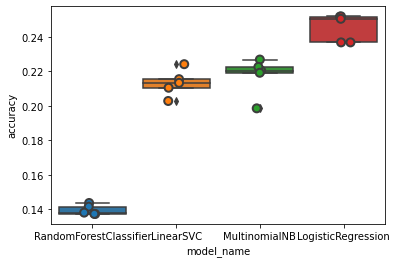

In [174]:
CV = 5

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

X = pd.concat([X_train_full, X_test_full])
Y = pd.concat([y_train, y_test])
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

RandomForestClassifier
LinearSVC
MultinomialNB
LogisticRegression


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

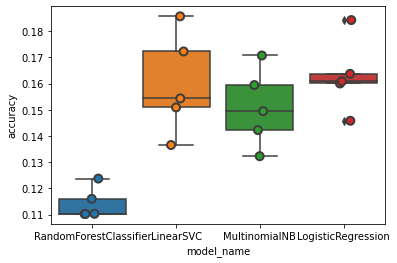

In [175]:
CV = 5

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
X = pd.concat([X_train_descr, X_test_descr])
Y = pd.concat([y_train, y_test])

for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

LinearSVC


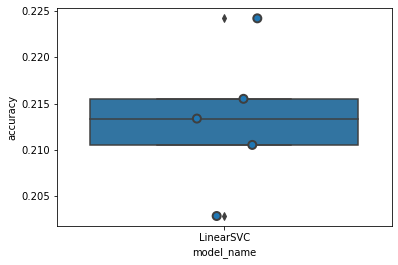

In [176]:
CV = 5

models = [
    LinearSVC(max_iter=4000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

X = pd.concat([X_train_full, X_test_full])
Y = pd.concat([y_train, y_test])
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

LogisticRegression


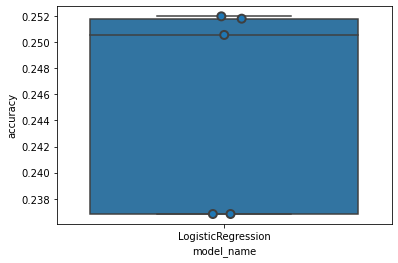

In [177]:
CV = 5

models = [
    LogisticRegression(random_state=0, max_iter=400),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

X = pd.concat([X_train_full, X_test_full])
Y = pd.concat([y_train, y_test])
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

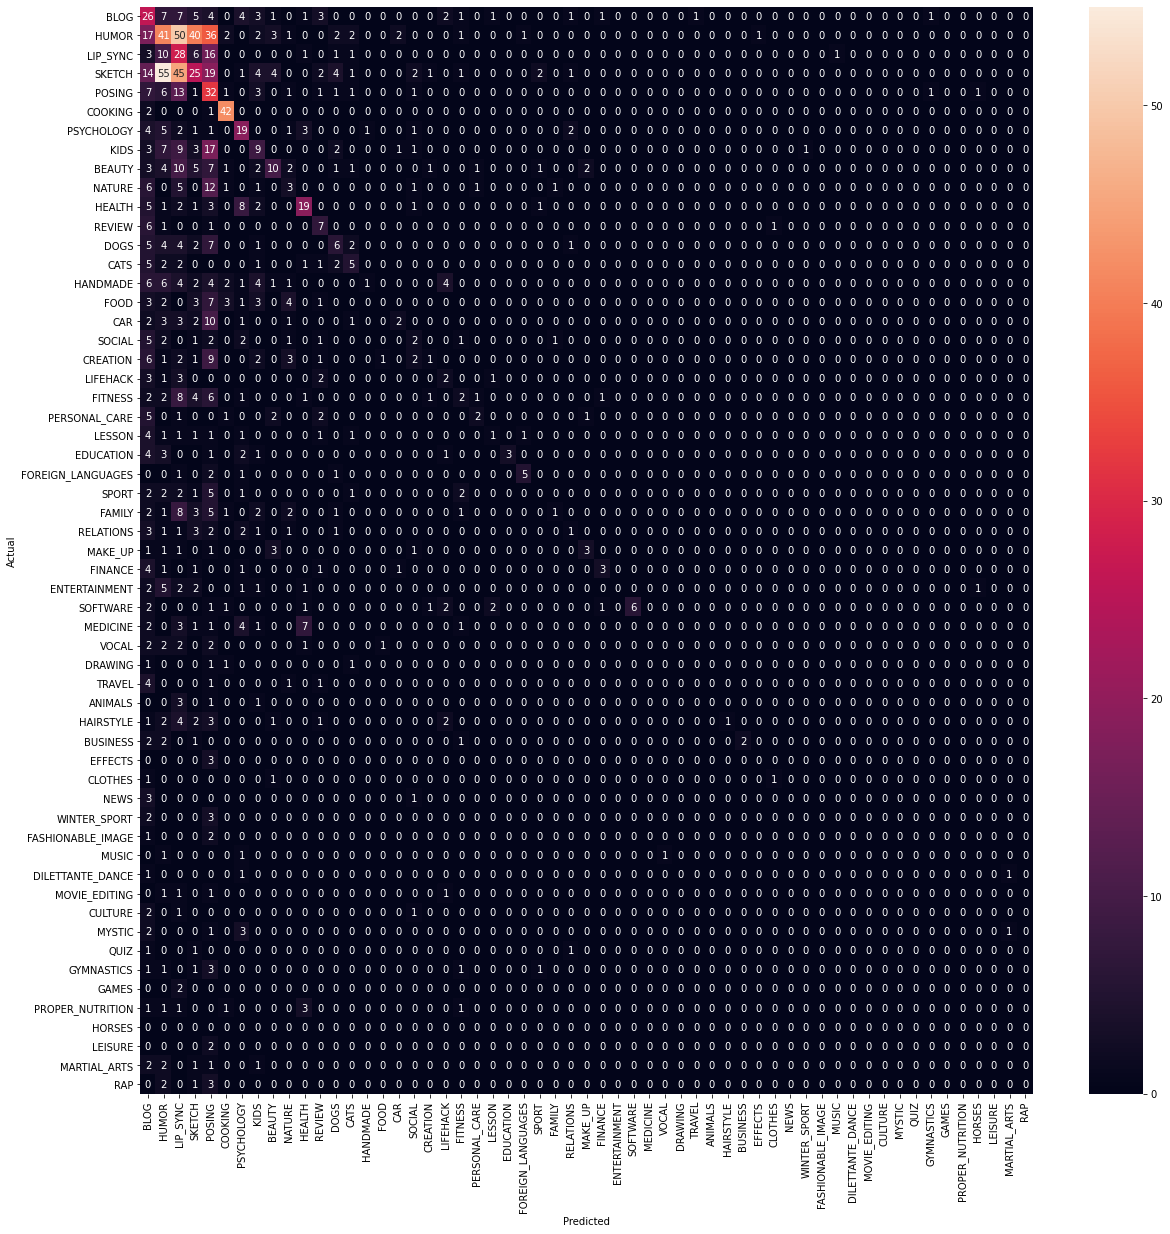

In [11]:
model = LogisticRegression(random_state=0, max_iter=400)

model.fit(X_train_full, y_train)
y_pred = model.predict(X_test_full)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=meta[1].values(), yticklabels=meta[1].values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

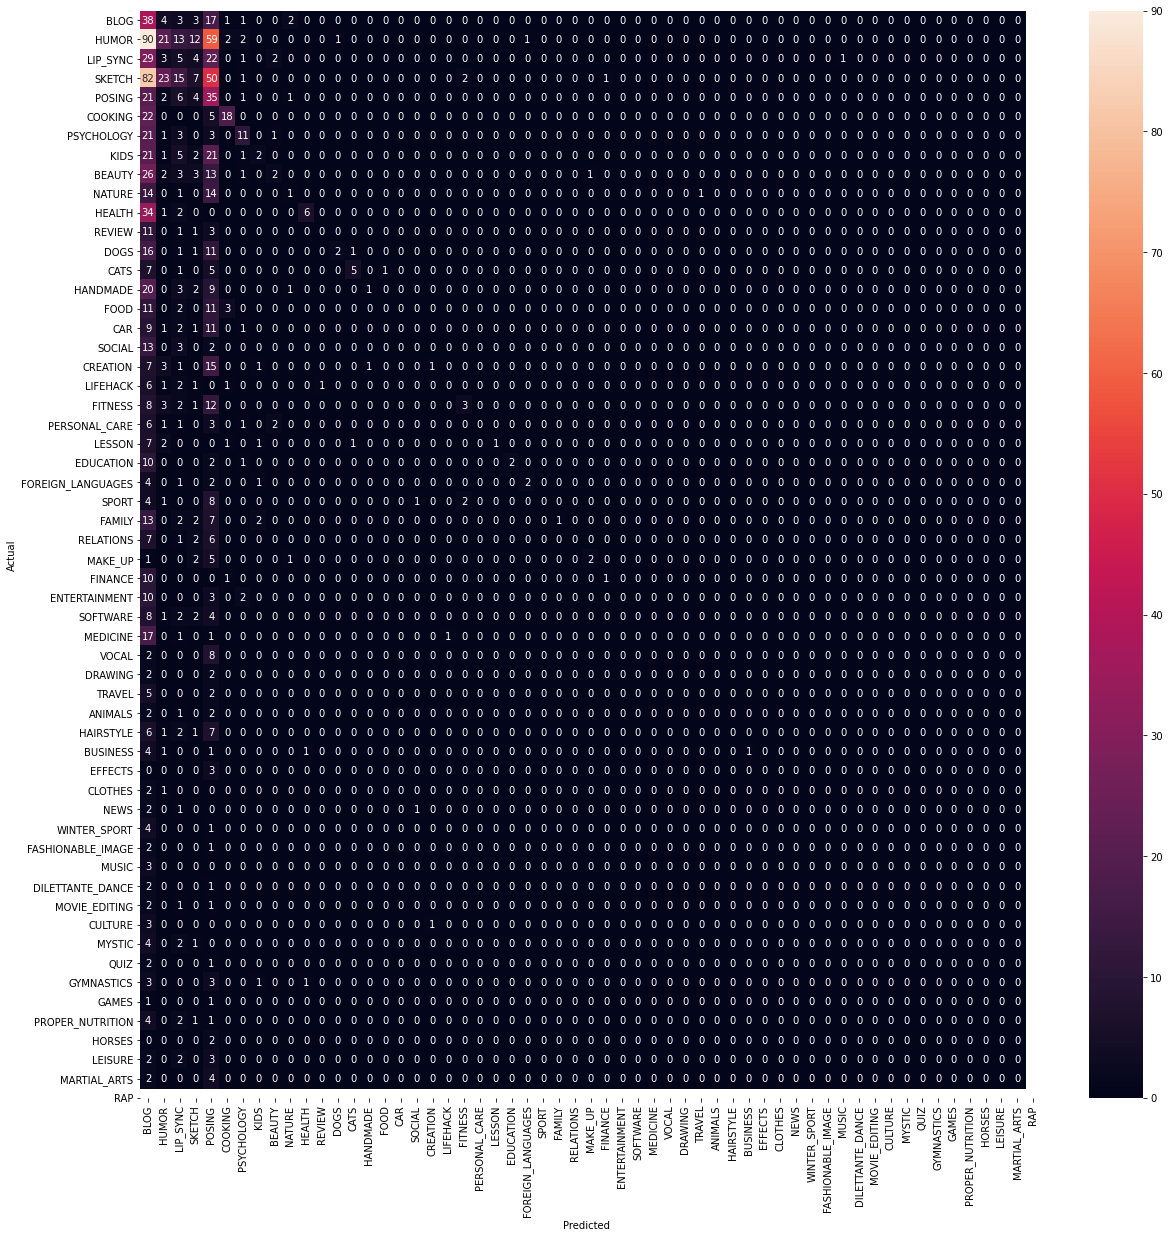

In [13]:
model = LogisticRegression(random_state=0, max_iter=400)

model.fit(X_train_descr, y_train)
y_pred = model.predict(X_test_descr)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=meta[1].values(), yticklabels=meta[1].values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
ALPHA = 0.25
q = np.quantile(clips['confidence_asr'], ALPHA)

X_train_cuted, X_test_cuted, y_train_cuted, y_test_cuted, meta_cuted = my_split(clips[clips['confidence_asr'] > q].copy())

(4216, 3)
(4216,)
(1055, 3)
(1055,)


In [36]:
X_train_descr_cuted, X_test_descr_cuted, X_train_full_cuted, X_test_full_cuted = BoW(X_train_cuted, X_test_cuted)

Only descr shape
(4216, 5768)
(1055, 5768)
Descr and asr shape
(4216, 19701)
(1055, 19701)


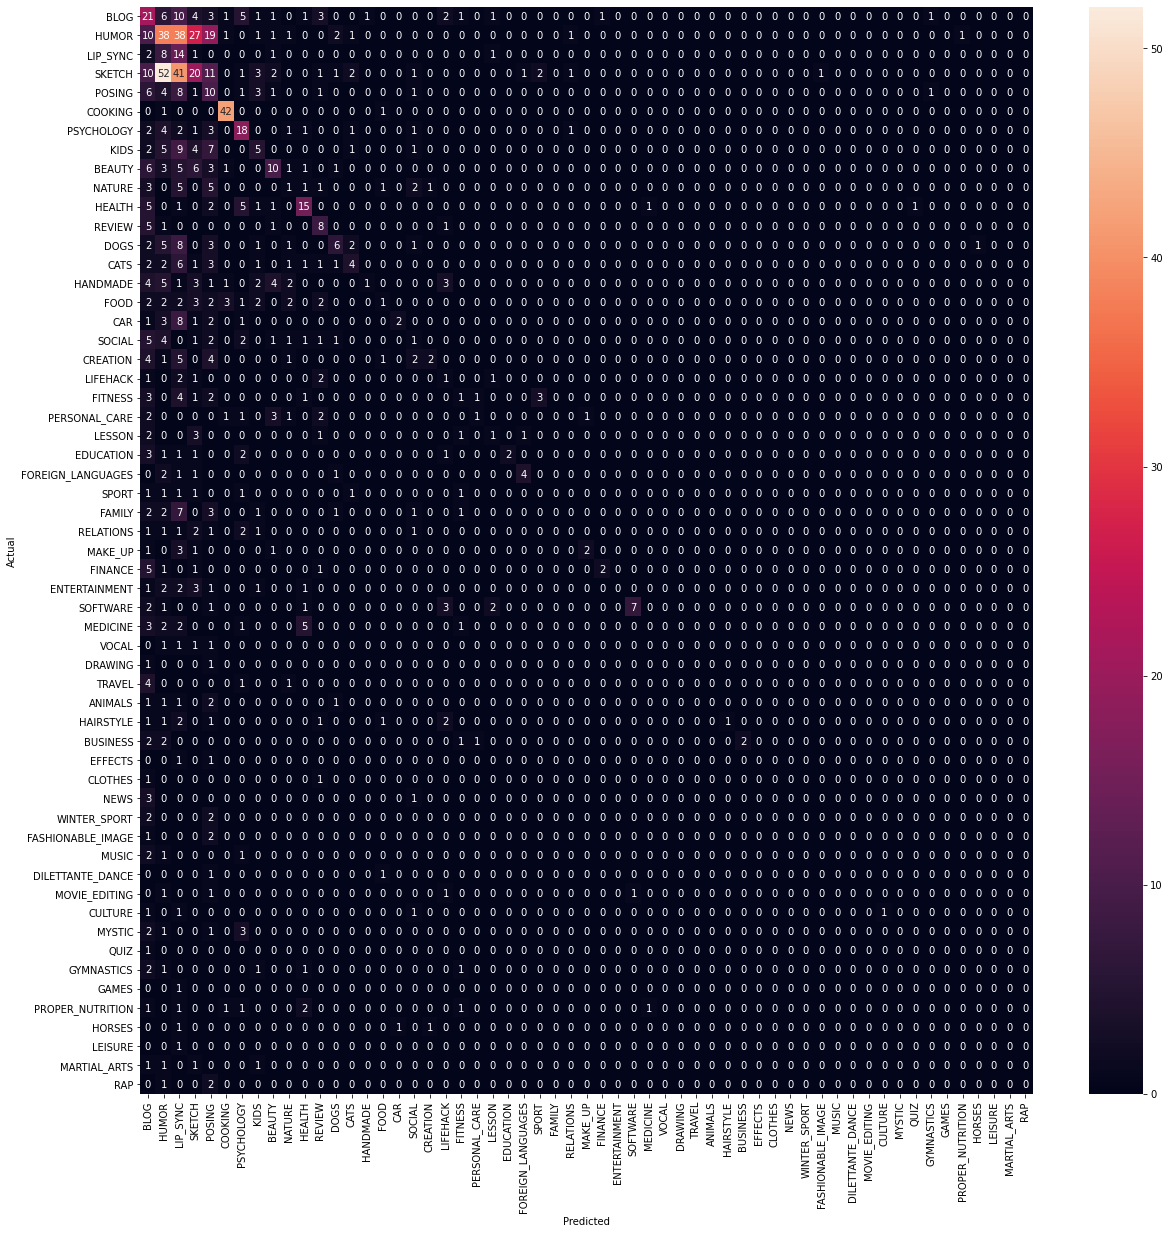

In [37]:
model = LogisticRegression(random_state=0, max_iter=400)

model.fit(X_train_full_cuted, y_train_cuted)
y_pred = model.predict(X_test_full_cuted)

conf_mat = confusion_matrix(y_test_cuted, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=meta_cuted[1].values(), yticklabels=meta_cuted[1].values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

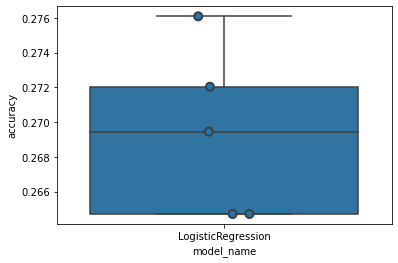

In [38]:
CV = 5

models = [
    LogisticRegression(random_state=0, max_iter=400),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

X = pd.concat([X_train_full_cuted, X_test_full_cuted])
Y = pd.concat([y_train_cuted, y_test_cuted])
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

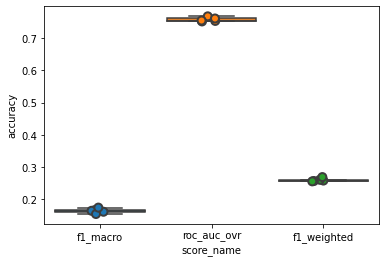

In [39]:
CV = 5

model = LogisticRegression(random_state=0, max_iter=400)

scors = [
    'f1_macro',
    'roc_auc_ovr',
    'f1_weighted',
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

X = pd.concat([X_train_full_cuted, X_test_full_cuted])
Y = pd.concat([y_train_cuted, y_test_cuted])
for score in scors:
    accuracies = cross_val_score(model, X, Y, scoring=score, cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((score, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['score_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='score_name', y='accuracy', data=cv_df)
sns.stripplot(x='score_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()